In [160]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [161]:
data_loc = "D:/Beam Characterization/2019_5_6/"
fname = "2019_05_06_flowrate.hdf"

In [162]:
with h5py.File(data_loc+fname, 'r') as f:
    runs = list(f.keys())
    for name in f.keys():
        print(name)

1557180420 new_spot
1557180503 40sscm
1557180645 20sscm
1557180784 20sscm
1557180880 40sscm
1557180979 60sccm
1557181063 40sscm
1557181137 80sccm
1557181211 40sccm
1557181288 20sccm
1557181363 new_spot
1557181410 20sccm
1557181490 20sccm
1557181638 40sccm
1557181715 60sccm
1557181790 40sccm
1557181854 20sccm
1557181865 20sccm
1557181940 20sccm
1557182089 80sccm
1557182168 40sccm
1557182272 60sccm
1557182425 40sccm
1557182498 20sccm
1557182573 80sccm
1557182647 40sccm
1557182723 20sccm


In [163]:
flow_rates = [20,40,60,80]
flow_runs = dict([(flow,[]) for flow in flow_rates])

bad_runs = ['1557180645 20sscm']

for run in runs:
    if run in bad_runs:
        continue
    try:
        flow = int(run[-6:-4])
        if flow in flow_runs:
            flow_runs[flow].append(run)
    except:
        continue

## Laser Locking HDF file

In [164]:
import glob
from datetime import datetime

fnames_locking = [f.split('\\')[-1] for f in glob.glob(data_loc+'/*.hdf5')]
fnames_locking = [f for f in fnames_locking if f[:4] == 'logS']
sorted(fnames_locking)

locking_data = {}
for fname_lock in fnames_locking:
    with h5py.File(data_loc+fname_lock, 'r') as f:
        tmp = []
        tmp.append(('timestamp', f['Time'].value))
        tmp.append(('frequency', f['RealFrequency'].value))
        tmp.append(('error', f['Errors'].value))
        tmp.append(('green_power',f['Power'].value))
        
        locking_data[datetime.strptime(fname_lock.strip('.hdf5')[5:], '%Y-%m-%d-%H.%M.%S')] = dict(tmp)

## Synchronizing timestamps

In [165]:
start_times = []

for flow in flow_rates:
    for run in flow_runs[flow]:
        with h5py.File(data_loc+fname, 'r') as f:
            grp = f[run]
            readout = grp['readout']
            fast_start = grp.attrs['time_offset']
            start_times.append((run, datetime.fromtimestamp(fast_start).strftime('%Y-%m-%d %H:%M:%S'), len(readout['PXIe-5171'])))

In [166]:
import datetime as dt
run_to_locking = {}
for run, start_time_run, len_run in start_times:
    tstart_run = datetime.strptime(start_time_run, '%Y-%m-%d %H:%M:%S')
    idx_locking_run = np.where(np.array(list(locking_data.keys())) < tstart_run)[0][-1]
    try:
        if tstart_run+dt.timedelta(seconds = len_run*1/2) > list(locking_data.keys())[idx_locking_run+1]:
            idx_locking_run += 1
    except IndexError:
        pass
    run_to_locking[run] = list(locking_data.keys())[idx_locking_run]

In [167]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_nearest_idx_with_rejection(array, value, reject_distance = 1):
    array = np.asarray(array)
    difference = (np.abs(array - value)).min()
    if difference >= reject_distance:
        return np.nan
    else:
        return (np.abs(array - value)).argmin()

(array([], dtype=int64), {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)})


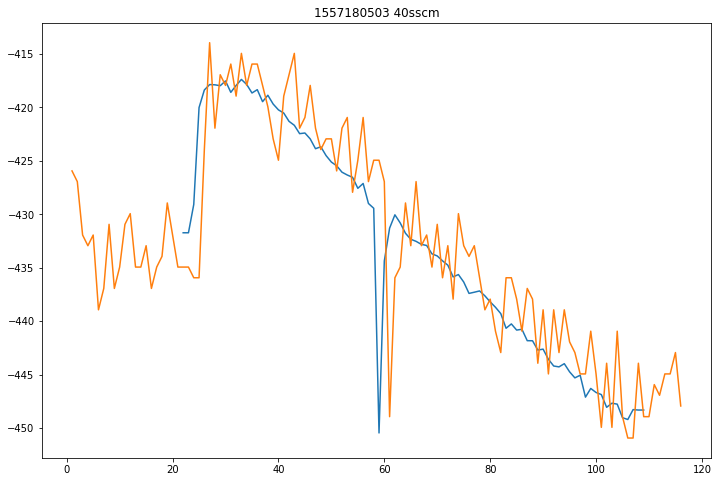

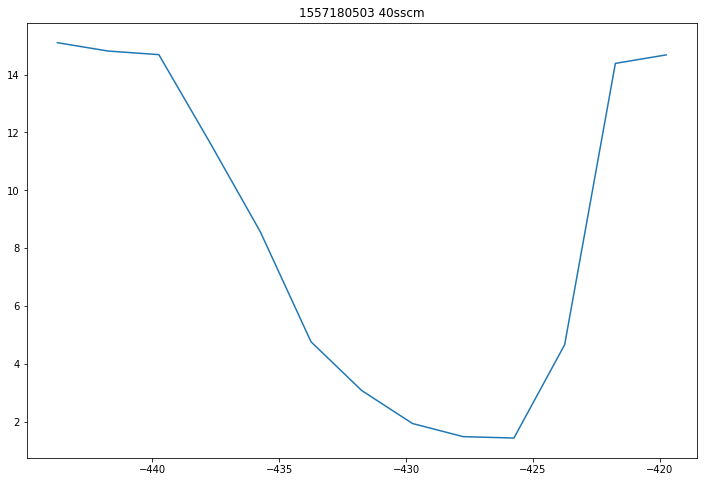

In [168]:
from lmfit import models
from lmfit import Model
from scipy.signal import find_peaks

flow_rate_peaks = {}

for flow in flow_rates:
    flow_rate_peaks[flow] = []
    for run in flow_runs[flow]:
        fast_daq = {}
        with h5py.File(data_loc+fname, 'r') as f:
            grp = f[run]
            readout = grp['readout']
            wavemeter = readout['Bristol671A'].value
            fast_start = grp.attrs['time_offset']
            for dset in readout['PXIe-5171'].items():
                fast_daq[dset[0]] = dset[1].value
    
        # grabing the dictinary key for the correct locking data file for each fast data acquisition run
        locking = run_to_locking[run]
        
        # grabbing the timestamps from the locking data
        timestamps_locking = locking_data[locking]['timestamp'].astype(float)+locking.timestamp()
        frequencies_locking = -1*locking_data[locking]['frequency']
        
        # only selecting datasets where the yag was fired
        yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]
        
        if len(yag_fire) == 0:
            continue
        
        # grabbing corresponding wavemeter readout values        
        rate = 1/2
        wavelength_values = []
        for idx in yag_fire:
            wavelength_values.append((idx, wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
        wavelength_values = np.array(wavelength_values) 
        
        # grabbing corresponding locking frequency from locking hdf file
        rate = 1/2
        frequency_values = []
        for idx in yag_fire:
            closest_idx = find_nearest_idx_with_rejection(timestamps_locking, idx*rate+fast_start-1.5)
            if not np.isnan(closest_idx):
                frequency_values.append((idx,frequencies_locking[closest_idx]))
        frequency_values = np.array(frequency_values)
        if len(frequency_values) == 0:
            continue

#         fig, ax = plt.subplots(figsize = (12,8))
#         ax.plot(frequency_values[:,0], frequency_values[:,1]-frequency_values[:,1].mean())
#         ax.plot(wavelength_values[:,0], (wavelength_values[:,1]-wavelength_values[:,1].mean())*1e6)
#         ax.set_title(run)

        # integrating the pmt signal and subtracting the background
        integrals = []
        dx = 1/1e5 # 100 kHz acquisition rate
        for idx in yag_fire:
            # Check if UV is on
            if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
                data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
                background = np.trapz(data_f[:100], dx=dx)
                signal = np.trapz(data_f[200:1100], dx=dx)-9*background
                integrals.append((idx,signal*-1,background*-1))
        integrals = np.array(integrals)
        
        # making an array with the integral amplitude and corresponding frequency
        frequency_amp = []
        for val in frequency_values:
            idx_int = val[0]
            frequency_amp.append((dict(frequency_values)[idx_int], val[1], idx_int))
        frequency_amp = np.array(frequency_amp)

        # putting each up and down part of a scan in a separate list entry to fit the peaks separately
        freq_low, freq_high = -445, -420
        left = np.where(np.diff(((frequency_values[:,1] > freq_low) & (frequency_values[:,1] < freq_high)).astype(int)) == -1)[0]+1
        right = np.where(np.diff(((frequency_values[:,1] > freq_low) & (frequency_values[:,1] < freq_high)).astype(int)) == 1)[0]+1
        indices = np.sort(np.append(left, right))
        indices = np.append(np.array([0]),indices)
        indices = np.append(indices, [len(frequency_values)])
        del left, right

        split_points = [0]
        for l,r in zip(indices[:-1], indices[1:]):
            vals = frequency_values[l:r,1]
            if (r-l >= 5) & ((vals.min() < freq_low) or (vals.max() > freq_high)):
                split_points.append(int(np.mean([l,r])))
        split_points.append(len(frequency_values))
        
        # grabbing the frequencies and peak integrals from the up and down scans
        scans = []
        for l,r in zip(split_points[:-1], split_points[1:]):
            if r-l > 50:
                scans.append([frequency_values[l:r,1], integrals[l:r,1]])
        
        # fitting each up and down scan separately
        for f, i in scans:
            fit_array = np.array([f[f.argsort()], i[f.argsort()]]).T
            
            # removing data points with frequencies outside of the peak range
            fit_array = fit_array[(fit_array[:,0] > freq_low) & (fit_array[:,0] < freq_high)]

            # binning the data to get a crude estimate of the error on each frequency value
            df = 2
            f_bins = np.arange(fit_array[:,0].min(), fit_array[:,0].max()+df, df)
            bin_indices = np.digitize(fit_array[:,0], f_bins)
            bin_means = np.array([fit_array[:,1][bin_indices == i].mean() for i in range(1, len(f_bins))])
            bin_errors = np.array([fit_array[:,1][bin_indices == i].std() for i in range(1, len(f_bins))])
            midpoint = np.diff(f_bins)/2+f_bins[:-1]

            mask_nan = ~np.isnan(bin_means)
            bin_means = bin_means[mask_nan]
            bin_errors = bin_errors[mask_nan]
            midpoint = midpoint[mask_nan]
        
            # finding the peak parameters such as height, center, and width
            minimum_peak_height = 2
            distance = np.ceil(1/np.diff(midpoint)[0])
            width = 3/np.diff(midpoint)[0]
            peaks = find_peaks(bin_means, height = minimum_peak_height, threshold = None, distance = distance, width = width)
            
            # fitting the peak (Voigt) plus a constant offset
            def offset(x, offset):
                return np.ones(len(x))*offset
            
            model_bg = Model(offset)
            model_peak = models.VoigtModel(prefix = 'Q23_')
            model = model_bg + model_peak
            try:
                sigma = np.diff(midpoint)[0]*peaks[1]['widths'][0]/(2*1.6)
            except Exception as e:
                print(peaks)
                fig, ax = plt.subplots(figsize = (12,8))
                ax.plot(frequency_values[:,0], frequency_values[:,1])
                ax.plot(wavelength_values[:,0], (wavelength_values[:,1]-wavelength_values[:,1].mean())*1e6+frequency_values[:,1].mean())
                ax.set_title(run)
                fig, ax = plt.subplots(figsize = (12,8))
                ax.plot(midpoint, bin_means)
                ax.set_title(run)
                continue
#                 raise e
            center = midpoint[peaks[0][0]]
            height = peaks[1]['peak_heights'][0]*np.sqrt(2*np.pi*sigma**2)*1.5
            params = {'offset': bin_means.min(),
                      'Q23_sigma': sigma, 
                      'Q23_center': center, 
                      'Q23_amplitude': height}
            result = model.fit(bin_means, **params, x=midpoint, weights = bin_errors)
            flow_rate_peaks[flow].append((run, result))         
            
#             fig, ax = plt.subplots(figsize = (12,8))
#             ax.errorbar(midpoint,bin_means, yerr = bin_errors, fmt = '.', ecolor = 'C3', zorder = -1)
#             ax.plot(midpoint, result.best_fit, 'k-', lw = 2)
#             ax.tick_params(axis='both', which='major', labelsize=15)
#             ax.tick_params(axis='both', which='minor', labelsize=15)
#             ax.set_xlabel('frequency IR [MHz]', fontsize = 15)
#             ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);
#             ax.set_title(run, fontsize = 15)

One run apparently has a dip where there is supposed to be a peak, not sure what is going on here. Have enough other runs @40 sccm that this is not a problem.

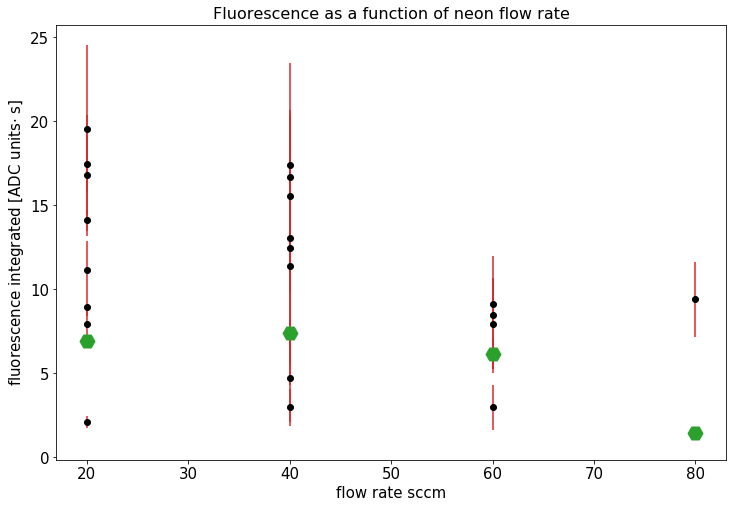

In [169]:
def weighted_mean(vals, weights):
    mean = np.sum(np.array(vals)*np.array(weights))/np.sum(weights)
    stderr = 1/(np.sqrt(np.sum(weights)))
    return mean, stderr

fig, ax = plt.subplots(figsize = (12,8))

for flow in flow_rates:
    m, w = [], []
    for val in flow_rate_peaks[flow]:
        if val[1].params['Q23_height'].stderr > 20:
            continue
        m.append(val[1].params['Q23_height'].value)
        w.append(1/val[1].params['Q23_height'].stderr**2)
        ax.errorbar(flow, val[1].params['Q23_height'].value, yerr = val[1].params['Q23_height'].stderr, fmt ='.', ecolor = 'C3', ms = 12, color = 'k')
    wm, wstderr = weighted_mean(m,w)
    ax.errorbar(flow, wm, yerr = wstderr, fmt ='H', ecolor = 'C3', ms = 15, color = 'C2')

ax.set_title('Fluorescence as a function of neon flow rate', fontsize = 16)
ax.set_xlabel('flow rate sccm', fontsize = 15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)

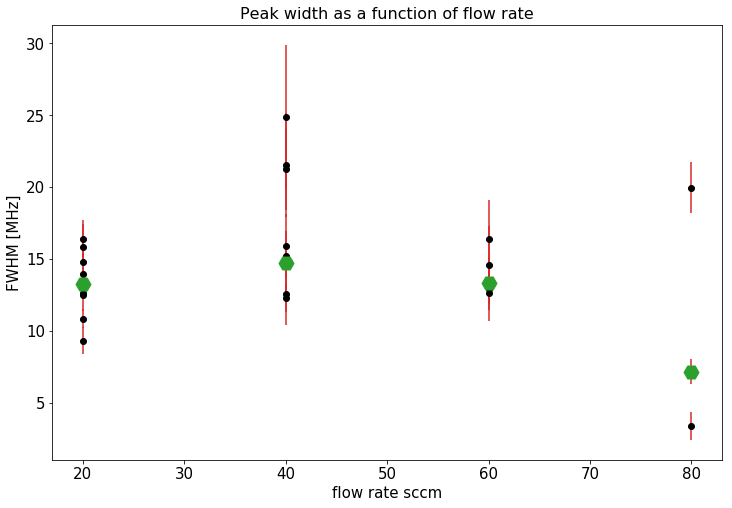

In [170]:
fig, ax = plt.subplots(figsize = (12,8))

for flow in flow_rates:
    m, w = [], []
    for val in flow_rate_peaks[flow]:
        if val[1].params['Q23_height'].stderr > 20:
            continue
        m.append(val[1].params['Q23_fwhm'].value)
        w.append(1/val[1].params['Q23_fwhm'].stderr**2)
        ax.errorbar(flow, val[1].params['Q23_fwhm'].value, yerr = val[1].params['Q23_fwhm'].stderr, fmt ='.', ecolor = 'C3', ms = 12, color = 'k')
    wm, wstderr = weighted_mean(m,w)
    ax.errorbar(flow, wm, yerr = wstderr, fmt ='H', ecolor = 'C3', ms = 15, color = 'C2')

ax.set_title('Peak width as a function of flow rate', fontsize = 16)
ax.set_xlabel('flow rate sccm', fontsize = 15)
ax.set_ylabel('FWHM [MHz]', fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)

FWHM = 13.18 +/- 0.17 MHz


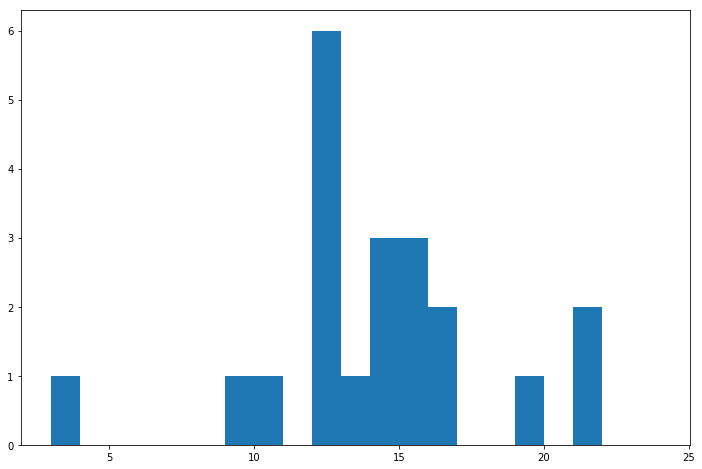

In [171]:
m, w = [], []
for flow in flow_rates:
    for val in flow_rate_peaks[flow]:
        if val[1].params['Q23_height'].stderr > 20:
            continue
        m.append(val[1].params['Q23_fwhm'].value)
        w.append(1/val[1].params['Q23_fwhm'].stderr**2)
fig, ax = plt.subplots(figsize = (12,8))
ax.hist(m, bins = np.arange(3,25,1))
ax.set_xlabel('')
wm, wstderr = weighted_mean(m,w)
print('FWHM = {0:.2f} +/- {1:.2f} MHz'.format(wm, wstderr))